# **Loading Dataset**

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import zipfile
from pathlib import Path

# Path to the zip file
zip_path = Path("/content/Mads_hackathon_dreamteam-main.zip")

# Directory where the zip will be extracted
extract_to = Path("/content/Mads_hackathon_dreamteam-main")

# Unzip the file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted {zip_path} to {extract_to}")

# Disable GPU usage if desired
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

Extracted /content/Mads_hackathon_dreamteam-main.zip to /content/Mads_hackathon_dreamteam-main


In [2]:

# Paths to Parquet files
path_train = '/content/Mads_hackathon_dreamteam-main/Mads_hackathon_dreamteam-main/data/raw/heart_big_train.parq'
path_valid = '/content/Mads_hackathon_dreamteam-main/Mads_hackathon_dreamteam-main/data/raw/heart_big_valid.parq'

# Load DataFrames
df_train = pd.read_parquet(path_train)
df_valid = pd.read_parquet(path_valid)

# Splitting Features (X) and Target (y)
X_train = df_train.iloc[:, :-1].values
y_train = df_train.iloc[:, -1].values

X_valid = df_valid.iloc[:, :-1].values
y_valid = df_valid.iloc[:, -1].values

# Scaling Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

# **Data Balancing**

In [3]:

# Function to balance classes to the average count
def balance_to_average(X, y):
    unique_classes, counts = np.unique(y, return_counts=True)
    avg_count = int(np.mean(counts))
    balanced_X, balanced_y = [], []
    for cls in unique_classes:
        X_cls = X[y == cls]
        y_cls = y[y == cls]
        if len(y_cls) < avg_count:
            X_resampled, y_resampled = resample(X_cls, y_cls, replace=True, n_samples=avg_count, random_state=42)
        else:
            X_resampled, y_resampled = resample(X_cls, y_cls, replace=False, n_samples=avg_count, random_state=42)
        balanced_X.append(X_resampled)
        balanced_y.append(y_resampled)
    balanced_X = np.vstack(balanced_X)
    balanced_y = np.hstack(balanced_y)
    return balanced_X, balanced_y


# Balance both training and validation datasets
X_train_balanced, y_train_balanced = balance_to_average(X_train, y_train)
X_valid_balanced, y_valid_balanced = balance_to_average(X_valid, y_valid)


# **Exploratory Data Analysis**

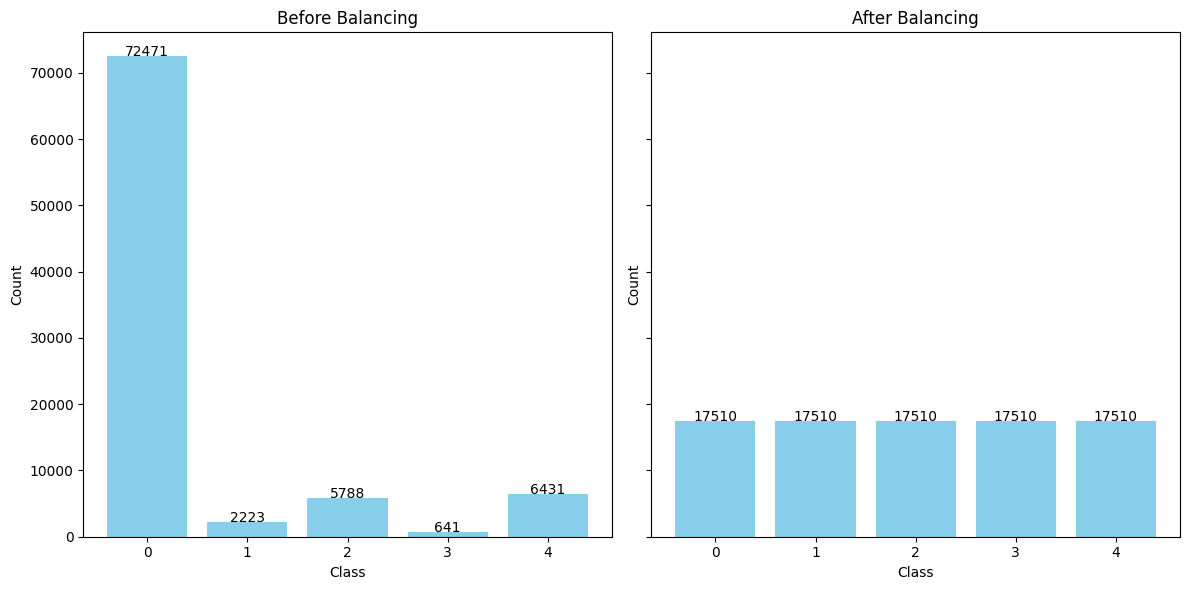

In [4]:
# Plotting function for class distributions
def plot_class_distribution(y, title, ax):
    unique, counts = np.unique(y, return_counts=True)
    ax.bar(unique, counts, color='skyblue')
    ax.set_xticks(unique)
    ax.set_title(title)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    for i, count in zip(unique, counts):
        ax.text(i, count + 5, str(count), ha='center', fontsize=10)

# Plot before and after balancing
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Before balancing
plot_class_distribution(y_train, "Before Balancing", axes[0])

# After balancing
plot_class_distribution(y_train_balanced, "After Balancing", axes[1])

plt.tight_layout()
plt.show()


In [5]:
# Import necessary libraries for visualization
import seaborn as sns

# Basic Information about the Dataset
print("Training Dataset Information:")
print(df_train.info())
print("\nValidation Dataset Information:")
print(df_valid.info())


Training Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to target
dtypes: float64(188)
memory usage: 125.6 MB
None

Validation Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10946 entries, 0 to 10945
Columns: 188 entries, 0 to target
dtypes: float64(188)
memory usage: 15.7 MB
None


In [6]:

# Shape of the Datasets
print(f"Shape of Training Dataset: {df_train.shape}")
print(f"Shape of Validation Dataset: {df_valid.shape}")


Shape of Training Dataset: (87554, 188)
Shape of Validation Dataset: (10946, 188)


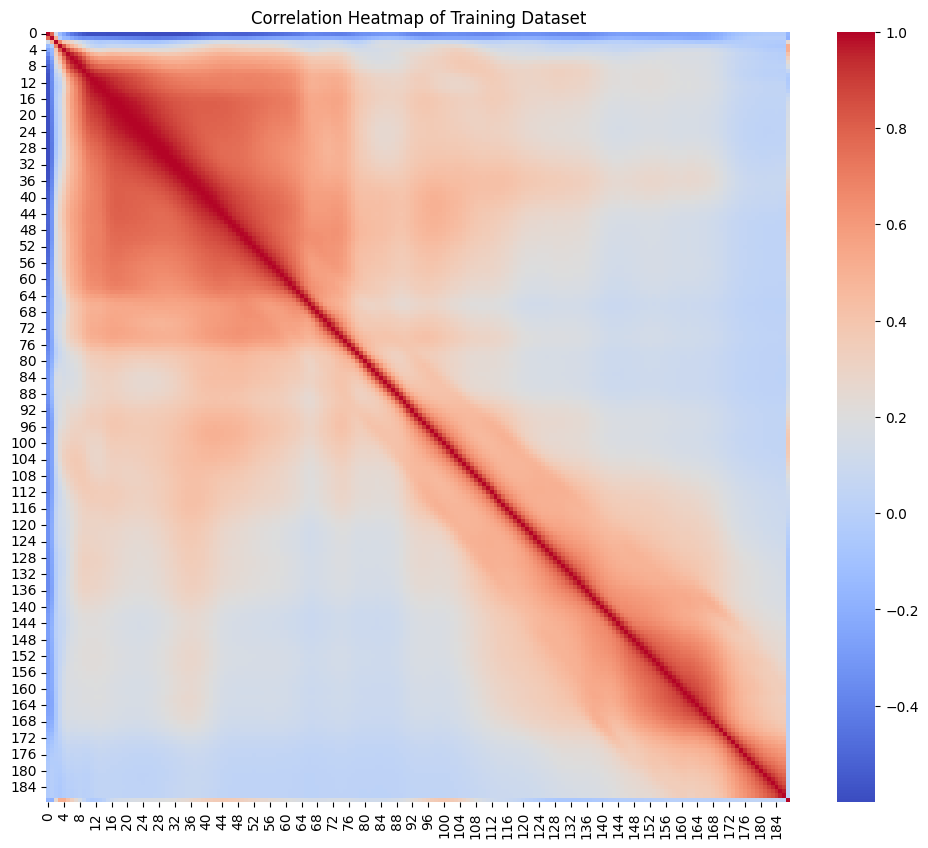

In [7]:
# Correlation Matrix Heatmap for the Training Dataset
plt.figure(figsize=(12, 10))
sns.heatmap(df_train.corr(), cmap="coolwarm", annot=False, fmt=".2f")
plt.title("Correlation Heatmap of Training Dataset")
plt.show()

# **Training of Multi_class_neural_network_model**

In [8]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_balanced, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_balanced, dtype=torch.long)
X_valid_tensor = torch.tensor(X_valid_balanced, dtype=torch.float32)
y_valid_tensor = torch.tensor(y_valid_balanced, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)

# Define Neural Network Model
class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 128)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout1(x)
        x = self.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the model, loss, and optimizer
input_size = X_train_tensor.shape[1]
num_classes = len(np.unique(y_train_balanced))
model = NeuralNet(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    # Training phase
    model.train()
    train_loss, correct_train = 0, 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        correct_train += (outputs.argmax(dim=1) == y_batch).sum().item()
    train_accuracy = correct_train / len(train_loader.dataset)

    # Validation phase
    model.eval()
    val_loss, correct_val = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            val_loss += loss.item()
            correct_val += (outputs.argmax(dim=1) == y_batch).sum().item()
    val_accuracy = correct_val / len(valid_loader.dataset)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss/len(valid_loader):.4f}, Val Acc: {val_accuracy:.4f}")

Epoch 1/20, Train Loss: 0.4935, Train Acc: 0.8189, Val Loss: 0.3445, Val Acc: 0.8729
Epoch 2/20, Train Loss: 0.3240, Train Acc: 0.8810, Val Loss: 0.2950, Val Acc: 0.8974
Epoch 3/20, Train Loss: 0.2775, Train Acc: 0.8993, Val Loss: 0.2937, Val Acc: 0.9043
Epoch 4/20, Train Loss: 0.2468, Train Acc: 0.9110, Val Loss: 0.2938, Val Acc: 0.9115
Epoch 5/20, Train Loss: 0.2300, Train Acc: 0.9186, Val Loss: 0.2751, Val Acc: 0.9204
Epoch 6/20, Train Loss: 0.2142, Train Acc: 0.9247, Val Loss: 0.3071, Val Acc: 0.9145
Epoch 7/20, Train Loss: 0.2024, Train Acc: 0.9284, Val Loss: 0.2776, Val Acc: 0.9254
Epoch 8/20, Train Loss: 0.1953, Train Acc: 0.9312, Val Loss: 0.3010, Val Acc: 0.9179
Epoch 9/20, Train Loss: 0.1870, Train Acc: 0.9358, Val Loss: 0.2939, Val Acc: 0.9330
Epoch 10/20, Train Loss: 0.1810, Train Acc: 0.9366, Val Loss: 0.2766, Val Acc: 0.9266
Epoch 11/20, Train Loss: 0.1757, Train Acc: 0.9398, Val Loss: 0.2700, Val Acc: 0.9332
Epoch 12/20, Train Loss: 0.1680, Train Acc: 0.9420, Val Loss: 0

# **Model Evaluation**

In [9]:

# Evaluate the model
model.eval()
y_valid_preds = []
with torch.no_grad():
    for X_batch, _ in valid_loader:
        X_batch = X_batch.to(device)
        outputs = model(X_batch)
        y_valid_preds.extend(outputs.argmax(dim=1).cpu().numpy())

# Metrics
accuracy_nn = accuracy_score(y_valid_balanced, y_valid_preds)
print(f"Neural Network Accuracy: {accuracy_nn:.4f}")
print("Classification Report:\n", classification_report(y_valid_balanced, y_valid_preds))

Neural Network Accuracy: 0.9243
Classification Report:
               precision    recall  f1-score   support

         0.0       0.85      0.92      0.88      2189
         1.0       0.93      0.89      0.91      2189
         2.0       0.90      0.96      0.93      2189
         3.0       0.97      0.88      0.92      2189
         4.0       0.99      0.97      0.98      2189

    accuracy                           0.92     10945
   macro avg       0.93      0.92      0.92     10945
weighted avg       0.93      0.92      0.92     10945



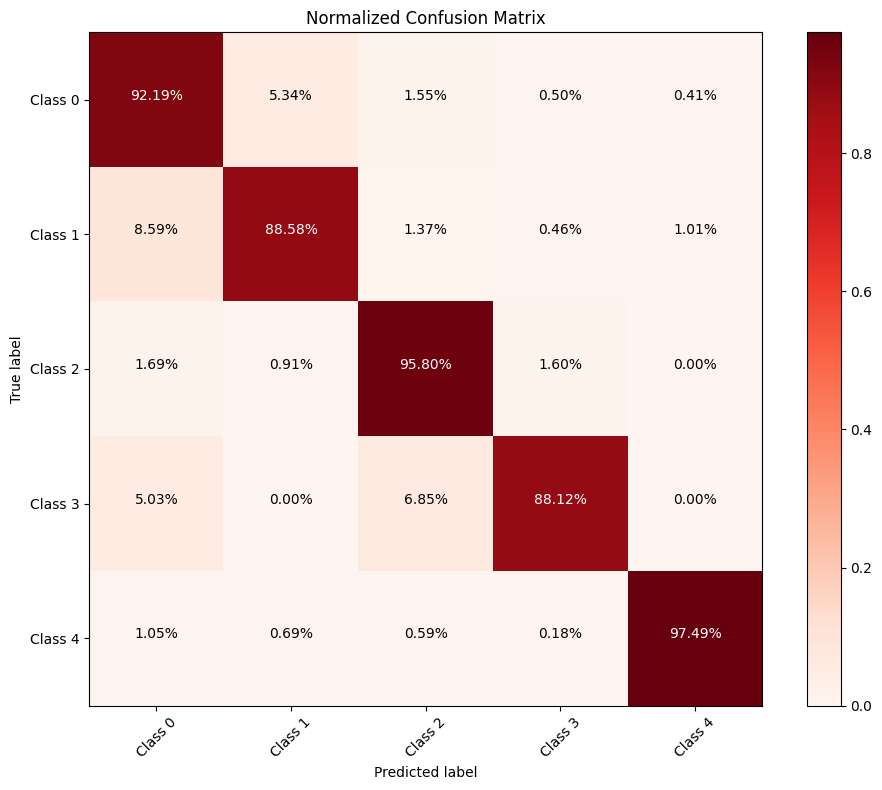

In [10]:
# Confusion Matrix
cm = confusion_matrix(y_valid_balanced, y_valid_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot Confusion Matrix
def plot_confusion_matrix_normalized(cm, class_names):
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.get_cmap('Reds'))
    plt.title("Normalized Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, f"{cm[i, j]:.2%}", horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

class_names = [f"Class {i}" for i in range(num_classes)]
plot_confusion_matrix_normalized(cm_normalized, class_names)
plt.show()

# **Multi class neural network model**

[Reference Diagram of Multi class neural network model](https://towardsdatascience.com/designing-your-neural-networks-a5e4617027ed)

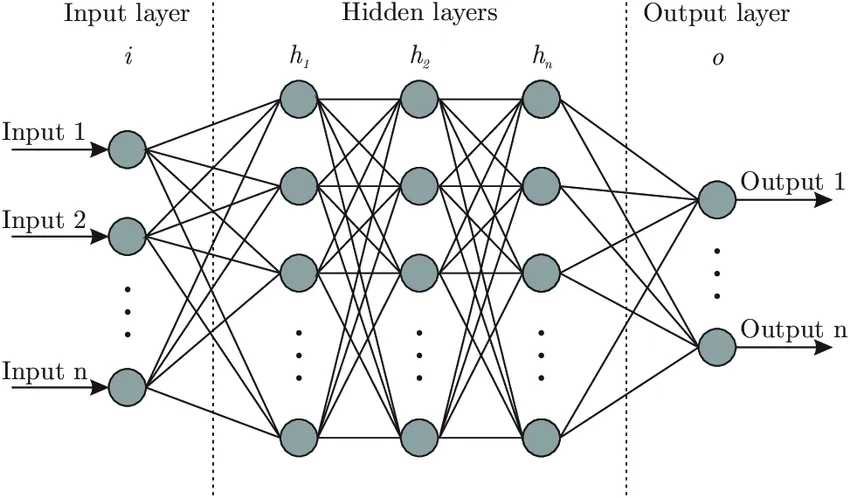

# **Issues in Existing Model and Improvement**

The existing model addresses class imbalance using SMOTE, which balances the dataset by taking the average of label values and generating synthetic samples to equalize class distribution. While this method helps mitigate imbalance, it can inadvertently introduce noise or create data that doesn't fully represent real-world scenarios, which may impact model performance.

The updated Multi-Class Neural Network model refines the architecture and addresses critical shortcomings. It enhances feature extraction by adding more layers and employing refined dropout regularization to mitigate overfitting. These improvements ensure better generalization and robustness. Moreover, the training pipeline is optimized with accurate performance evaluation metrics, providing a more reliable assessment of the model's capabilities.

The performance of class 1, which was notably poor in the existing model, has significantly improved in the updated model due to these architectural refinements and balanced training, showcasing the model's ability to handle diverse classes effectively. The use of dropout layers, sparse categorical cross-entropy loss, and the Adam optimizer further contribute to the model's overall efficacy in multi-class classification tasks.

# **Weak Points in Existing Model**

1. Class Imbalance Handling
2. Lack of Data Augmentation
3. Overfitting Risk
4. Limited Early Stopping Configuration
5. Shallow Network Depth
6. Model Optimization
7. Manual Resampling with SMOTE